In [1]:
# Author: Yuki Rivera
# This notebook contains code to fine-tune the pretrained bart-base model with our anime project dataset

### Install required libraries 

In [ ]:
!pip install datasets matplotlib pandas numpy accelerate scikit-learn

In [ ]:
!pip install transformers==4.51.3

### Set the path for storage

In [1]:
path = "./"

In [2]:
output_dir = path + "results/"
logging_dir = output_dir + "logs/"

In [5]:
import os

os.makedirs(output_dir, exist_ok=True)
os.makedirs(logging_dir, exist_ok=True)

### Import necessary libraries

In [6]:
from transformers import BartTokenizer, BartForConditionalGeneration, Trainer, TrainingArguments, DataCollatorForSeq2Seq
from transformers import EarlyStoppingCallback
from datasets import Dataset
import pandas as pd
import torch
import math
import numpy as np
from torch.nn import CrossEntropyLoss
import os
import json
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import glob
from sklearn.metrics import log_loss

### Loads the training data

In [7]:
df = pd.read_csv("prompt_synopsis_train.csv")
df = df[["prompt", "synopsis"]].dropna()

# Converts to HuggingFace Dataset for Trainer compatibility
dataset = Dataset.from_pandas(df)

### Loads the tokenizer and the model

In [ ]:
tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-base")

### Hyperparameters to use for training

In [ ]:
# flag to whether or not to use the full dataset
use_full_data = True

# number of rows to use for training
num_rows_to_use = 10000  # Ignored if use_full_data is True

# max # of tokens
enc_max_len = 64  
dec_max_len = 150

random = 42
validation_ratio = 0.2

# variables to set for the training
epochs = 10   
batch_size = 32   
log_steps = 200   
save_limit = 2   
stopping_patience = 3  
eval_steps = 500  

# learning rate 
alpha = 3e-5 
# helps prevent overfitting
weight_decay = 0.01  

scheduler_type = 'linear' 
# simulates larger batches without more memory
accumulation_steps = 2  
# warmup_step ratio (helps stabilize training early on)
ratio = 0.1

In [ ]:
# computes warmup_steps depending on the size of data used
if use_full_data:
    total_samples = len(df)  
else:
    total_samples = num_rows_to_use
warmup_steps = int(ratio * (total_samples // batch_size) * epochs)

### Function to tokenize data

In [11]:
def tokenize_data(example):
    model_inputs = tokenizer(
        example["prompt"],
        truncation=True,
        max_length=enc_max_len
    )

    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            example["synopsis"],
            truncation=True,
            max_length=dec_max_len,
            add_special_tokens=True  
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs


### Prepare the training and validation sets

In [12]:
if use_full_data:
    df_sampled = dataset
else:
    df_sampled = dataset.shuffle(seed=random).select(range(num_rows_to_use))

In [13]:
# Splits the dataset to the training and the validation sets
split = df_sampled.train_test_split(test_size=validation_ratio, seed=42)
train_raw = split["train"]
eval_raw = split["test"]

In [14]:
# Applies the tokenizing function to both sets
train_dataset = train_raw.map(tokenize_data, batched=True)
eval_dataset = eval_raw.map(tokenize_data, batched=True)

Map:   0%|          | 0/48208 [00:00<?, ? examples/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:3980: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(


Map:   0%|          | 0/12052 [00:00<?, ? examples/s]

### Functions to use with Trainer

In [15]:
# For dynamically pad the data
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding="longest"
)

### Set up the training and trainer configurations

In [ ]:
training_args = TrainingArguments(
    output_dir=output_dir,
    num_train_epochs=epochs,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    logging_dir=logging_dir,
    logging_steps=log_steps,
    save_strategy="epoch",
    eval_strategy="epoch",
    eval_steps= eval_steps,
    save_steps = eval_steps,
    save_total_limit=save_limit,
    overwrite_output_dir=True,
    report_to=["none"],
    run_name="bart_run1",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    disable_tqdm=False,
    learning_rate=alpha,
    weight_decay=weight_decay,
    warmup_steps=warmup_steps,
    lr_scheduler_type=scheduler_type,
    gradient_accumulation_steps=accumulation_steps,
    fp16=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=stopping_patience)]
)


### Trains the model

In [18]:
trainer.train()

Epoch,Training Loss,Validation Loss
1,4.163000,3.639770
2,3.726600,3.299282
3,3.355300,2.971034
4,3.065900,2.715122
5,2.896600,2.513649
6,2.716600,2.356012
7,2.584400,2.237594
8,2.491400,2.154710
9,2.403200,2.089798


/usr/local/lib/python3.10/dist-packages/transformers/modeling_utils.py:3339: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(
There were missing keys in the checkpoint model loaded: ['model.encoder.embed_tokens.weight', 'model.decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=7530, training_loss=3.0535337815405046, metrics={'train_runtime': 2122.8662, 'train_samples_per_second': 227.089, 'train_steps_per_second': 3.547, 'total_flos': 1.265864333819904e+16, 'train_loss': 3.0535337815405046, 'epoch': 9.987392169873921})

### Saves the log file

In [19]:
final_dir = "final_model/"
os.makedirs(final_dir, exist_ok=True)

with open(final_dir + "trainer_log_history.json", "w") as f:
    json.dump(trainer.state.log_history, f, indent=2)

### Plot the loss curve

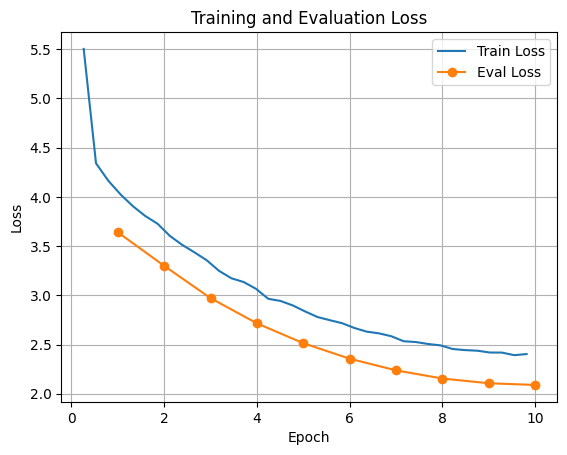

In [ ]:
log_history = trainer.state.log_history

train_loss = [(log["epoch"], log["loss"]) for log in log_history if "loss" in log]
eval_loss = [(log["epoch"], log["eval_loss"]) for log in log_history if "eval_loss" in log]

train_epochs, train_values = zip(*train_loss)
eval_epochs, eval_values = zip(*eval_loss)

plt.plot(train_epochs, train_values, label="Train Loss")
plt.plot(eval_epochs, eval_values, label="Eval Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Evaluation Loss")
plt.legend()
plt.grid(True)
plt.savefig(output_dir + "loss_curve_bart.png", dpi=300, bbox_inches="tight")
plt.show()


### Computes validation perplexity

In [23]:
eval_results = trainer.evaluate()
val_loss = eval_results["eval_loss"]
perplexity = math.exp(val_loss)
print(f"Best Model Perplexity: {perplexity:.2f}")

Best Model Perplexity: 8.08


### Saves the hyperparameters used and perplexity value to a text file

In [24]:
parameters = {'epochs':epochs, 'batch_size':batch_size, 'eval_steps':eval_steps, 'learning_rate':alpha,
              'patience':stopping_patience, 'validation_ratio':validation_ratio, 'scheduler_type':scheduler_type,
               'warmup_step_ratio':ratio, 'weight_decay': weight_decay,'perplexity':perplexity}

In [25]:
with open("results_parameters.txt", "w", encoding="utf-8") as f:
    for key, value in parameters.items():
        f.write(f"{key}: {value}\n")

### Saves the model weights + config

In [27]:
save_path = "final_model"
os.makedirs(save_path, exist_ok=True)

In [ ]:
trainer.save_model(save_path)           
tokenizer.save_pretrained(save_path)    

('final_model/tokenizer_config.json',
 'final_model/special_tokens_map.json',
 'final_model/vocab.json',
 'final_model/merges.txt',
 'final_model/added_tokens.json')

### Saves the model to a zip file due to the storage size issue

In [29]:
import shutil

shutil.make_archive("final_model", "zip", "final_model")

'/workspace/final_model.zip'

In [30]:
!du -h final_model.zip

493M	final_model.zip
